In [22]:
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import glob
from sklearn.svm import LinearSVC

def convert_color(img, conv):
    """
    颜色空间转换
    """
    return cv2.cvtColor(img, conv)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """
    提取图像的hog特征
    """
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    """
    提取图像的空间特征
    """
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
 
def color_hist(img, nbins=32):
    """
    颜色直方图
    """
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def extract_img_features(img):
    """
    把之上的图像处理方法进行综合，且对结果进行归一化处理
    """
    hist_feature = color_hist(img)
    spatial_feature = bin_spatial(img)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog_features = get_hog_features(gray_img, 9, 8, 2)
    features = np.concatenate((hist_feature, spatial_feature, hog_features))
    return features
    
img = cv2.imread("./vehicles/GTI_Far/image0000.png")
result = extract_img_features(img)
print(result.shape)

(4932,)


In [35]:
vehicles_file_paths = glob.glob("./vehicles/*/*.png")
non_vehicles_file_paths = glob.glob("./non-vehicles/*/*.png")
print("汽车样本数量：" , len(vehicles_file_paths))
print("非汽车样本数量：" , len(non_vehicles_file_paths))

汽车样本数量： 8792
非汽车样本数量： 8968


In [29]:
vehicle_lable = 1
non_vehicle_label = 0

# 读入数据,对图像进行特征提取
X = []
y = []
for path in vehicles_file_paths:
    img = cv2.imread(path)
    features = extract_img_features(img)
    X.append(features)
    y.append(vehicle_lable)

for path in non_vehicles_file_paths:
    img = cv2.imread(path)
    features = extract_img_features(img)
    X.append(features)
    y.append(non_vehicle_label)

In [36]:
# shuffle
X, y = shuffle(X, y)
# split
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
# scaller
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
# train
svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [41]:
# 测试训练结果
from sklearn.metrics import accuracy_score

predicts = svc.predict(X_test)
score = accuracy_score(predicts, y_test)
print(score)

1.0


10


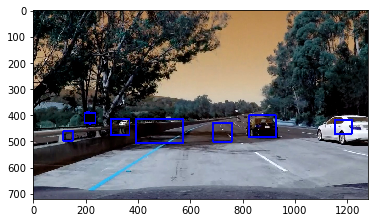

In [141]:
import matplotlib.pyplot as plt

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    # 只保留感兴趣区域
    img_tosearch = img[ystart:ystop,:,:]
    imshape = img_tosearch.shape
    
    # 图像按比例缩放
    if scale != 1:
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # 按照一次只移动一个cell来计算的
    nxblocks = (imshape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (imshape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # 计算整张图像的hog特征
    gray_img = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2GRAY)
    hog_features = get_hog_features(gray_img, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxs = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # 子hog特征
            hog_feature = hog_features[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if len(hog_feature) == 1764:
                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell
                if xleft < img_tosearch.shape[1] and ytop < img_tosearch.shape[0]:
                    # 子图像
                    subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))

                    # 空间特征
                    spatial_features = bin_spatial(subimg)


                    # 颜色特征
                    hist_features = color_hist(subimg)

                    # 特征组合
                    features = np.hstack((hist_features, spatial_features, hog_feature))
                    combined_features = X_scaler.transform([features])
                    # 预测
                    test_prediction = svc.predict(combined_features)

                    if test_prediction == 1:
                        xbox_left = np.int(xleft*scale)
                        ytop_draw = np.int(ytop*scale)
                        win_draw = np.int(window*scale)
                        boxs.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                        # cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
    return boxs
    
    
from scipy.ndimage.measurements import label
    
def detect_object():
    ystart = 350
    ystop = 650
    bbox_list = []
    img = cv2.imread("test_images/test1.jpg")
    for i in range(6, 14, 2):
        boxs = find_cars(img, ystart, ystop, i/10, svc, X_scaler, 9, 8, 2, 32, 32)
        bbox_list = bbox_list + boxs
    heatmap = np.zeros((img.shape[0], img.shape[1]))
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    heatmap[heatmap <= 30] = 0
    labels = label(heatmap)
    print(labels[1])
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    plt.imshow(img)
    plt.show()   

    
detect_object()